# COMP8220 Project - Facial Expression Recognition 

## Preparing the Data

### Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import csv
import pandas as pd
import seaborn as sns

from joblib import dump, load
%matplotlib inline

# SKLearn Model selection and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

# SKLearn Machine Learning models
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# SKImage
from os.path import join
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
from skimage.feature import hog

# Keras
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.models import Model, Sequential
from keras.applications.imagenet_utils import preprocess_input
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
#Google Colab Mount

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('./gdrive/My Drive/COMP8220/Project/') # Project Directory

Mounted at /content/gdrive


### Access the Dataset

In [45]:
image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']
EMOTIONS_new = ['happy', 'sad', 'neutral']
labels_new = [None, None, None, 0, 1, None, 2]

images_train = np.load('Datasets/Training_data_images.npy')
labels_train = np.load('Datasets/Training_data_labels.npy')

images_test_public = np.load('Datasets/PublicTest_data_images.npy')

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])

print('Training Images Shape:', images_train.shape)
print('Training Labels Shape:', labels_train.shape)
print('Public Images Shape:', images_test_public.shape)

Training Images Shape: (9328, 48, 48)
Training Labels Shape: (9328,)
Public Images Shape: (1136, 48, 48)


In [46]:
images_train_index = [(label in [3,4,6]) for label in labels_train]

labels_train_new = np.array([labels_new[label] for label in labels_train if label in [3,4,6]])
labels_train_new.shape

(5692,)

In [47]:
images_train_new = images_train[images_train_index]

images_train_new.shape

(5692, 48, 48)

In [48]:
labels_train_new

array([2, 0, 0, ..., 0, 0, 0])

Now that the training and test datasets have been accessed and reshaped accordingly, let's display some sample images from the training dataset with their corresponding labels.

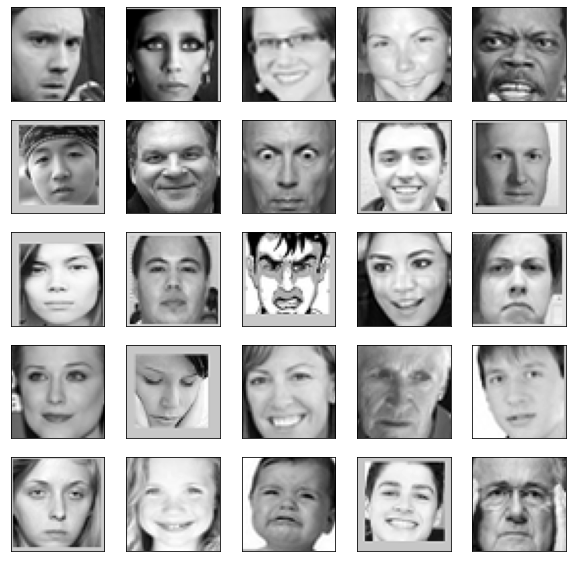

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel(EMOTIONS[labels_train[i]], color='white')
plt.show()

## Data Augmentation

In order to create further training data for the following Conventional and Deep Learning models, we will perform data augmentation on the Training dataset; specifically we will be mirroring the images and adding it to the training dataset.

### Mirror Images

In [49]:
X_augment = []
y_augment = []

for i in range(len(images_train_new)):
    flipped_image = cv2.flip(images_train_new[i], 1)
    X_augment.append(flipped_image)
    y_augment.append(labels_train_new[i])

In [50]:
X_augment = np.concatenate((np.array(images_train_new), np.array(X_augment)), axis=0)
y_augment = np.append(labels_train_new, np.array(y_augment))

print('Augmented Training Data:')
print(len(X_augment), 'Images')

print('\nOriginal Training Data:')
print(len(images_train_new), 'Images')

Augmented Training Data:
11384 Images

Original Training Data:
5692 Images


We can see above that the total number of training data was doubled due to the Data Augmentation process and thus created more training data for the following Conventional and Deep Learning models.

### Create DataFrame

We will now create a dataframe for all the training images and use it to display the number of instances for each classification label using a bar plot.

In [51]:
# Convert images into a data frame
images_train_df = pd.DataFrame([[image] for image in X_augment], columns = ['image'])

# Create labels column
images_train_df['labels'] = y_augment

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Emotion')

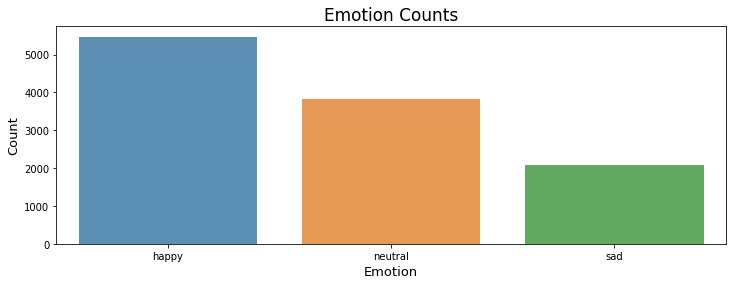

In [52]:
label_counts = images_train_df['labels'].value_counts()
label_index = [EMOTIONS_new[label] for label in label_counts.index]

plt.figure(figsize=(12,4))
sns.barplot(label_index, label_counts, alpha=0.8)

plt.title('Emotion Counts', fontsize=17)
plt.ylabel('Count', fontsize=13)
plt.xlabel('Emotion', fontsize=13)

Shown above is the count of images that are present in the whole dataset. It can be seen that there is an imbalance of classification labels in the dataset, with the 'happy' label having the most instances with more than 5000 images while the 'disgusted' label had the least number of images with only around 500 images. This imbalance could lead to poor performance of the classifier models that we'll be creating later.

### Split Dataset

With the created dataframe, we will now proceed in splitting our dataset into Training (80%) and Validation (20%) datasets. 

In [53]:
# Create Train and Validation data Split

X = list(images_train_df['image'].values)
y = list(images_train_df['labels'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=24)

## Feature Extraction

### Pixel Features

In order for the Conventional Machine Learning models to use the images as input, we first have to flatten each image into a single row vector containing (48*48 = 2304) 2304 elements pertaining to each pixel in the 48x48 image.

In [54]:
def flatten_image(image):
    return np.reshape(image, image_size*image_size)

In [55]:
# Flatten images into a row vector
X_train = np.array([flatten_image(image) for image in X_train])
X_valid = np.array([flatten_image(image) for image in X_valid])

print('Original Training Data Shape:', X_train.shape)
print('Validation Training Data Shape:', X_valid.shape)

Original Training Data Shape: (9107, 2304)
Validation Training Data Shape: (2277, 2304)


## Deep Learning Model

Before creating a Deep Learning model, we should first reshape our training and validation image data back to its original shape of 48x48 in order to be processed by the Convolutional layers. We will also convert the prediction labels of the training and validation data into one-hot vectors.

In [56]:
n_classes=len(EMOTIONS_new)

# Reshape Images to 48x48
images_train = np.array([np.reshape(image, (48,48)) for image in X_train])
images_valid = np.array([np.reshape(image, (48,48)) for image in X_valid])

print('Images Train Shape:', images_train.shape)
print('Images Validation Shape:', images_valid.shape)

# Convert labels to one-hot vectors       
labels_train = keras.utils.to_categorical(y_train, num_classes=n_classes)
labels_valid = keras.utils.to_categorical(y_valid, num_classes=n_classes)

print('Labels Train Shape:', labels_train.shape)
print('Labels Validation Shape:', labels_valid.shape)

Images Train Shape: (9107, 48, 48)
Images Validation Shape: (2277, 48, 48)
Labels Train Shape: (9107, 3)
Labels Validation Shape: (2277, 3)


### CNN

Now that the training and validation images and labels have been processed accordingly, we can now start with the creation of the CNN model.

We'll create a CNN model from scratch using the Keras Sequential API. To start the model, we will be using a reshape layer since our image dataset has a shape of 48x48 for each image. In order to use these images in the convolutional layers, we have to reshape each image to (48,48,1) which will be done through the reshape layer.

Next, in order to create additional training data for the CNN model, we will also be adding augmentation layers; specifically a RandomFlip and RandomRotation layer which will flip each input image horizontally and randomly rotate it as well. The addition of the augmentation layers will also help in reducing the risk of the CNN on overfitting the training data.

Once the reshaping and augmentation is done, then comes 6 sequential convolutional layers which are slightly modeled in the CNN model found [here](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). It involves the use of Conv2D Layers with increasing number of filters in powers of 32, 3x3 Kernel size. The Conv2D layers also made use of the 'Relu' activation function, 'He_Uniform' kernel initialization and used 'Same' padding in order to keep the initial shape of each Conv2D layer's respective inputs. This is then followed by a BatchNormalization layer, while some convolutional layers having an additional MaxPooling2D layer and dropout layers.

Finally, the final output of the 6 convolutional layers will go through a flatten layer for the incoming fully connected dense layers. The first dense layers will contain 128 neurons with 'Relu' activation and 'He_Uniform' kernel initializer. The output will then pass through a BatchNormalization layer and will include a dropout rate of 0.5 and then finally reach the output dense layer with 7 number of neurons and will use the 'Softmax' activation.

In [57]:
cnn_model = Sequential()

# Reshape Layer
cnn_model.add(keras.layers.Reshape((image_size, image_size, 1), input_shape=(image_size, image_size)))

# Add Augmentation Layers
cnn_model.add(RandomFlip('horizontal'))
cnn_model.add(RandomRotation(0.2))

# Convolution Layer 1
cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 2
cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.2))

# Convolution Layer 3
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 4
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

# Convolution Layer 5
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 6
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.4))

# Fully connected Dense Layers with dropout
cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(n_classes, activation='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 48, 48, 1)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 48, 48, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        1

To train the CNN model, we will be using a checkpoint callback which will monitor the 'val_loss' during fitting and be responsible in saving the model's best state with the lowest 'val_loss' value.

To compile the model, we will be using the 'categorical_crossentropy' loss function, 'Adam' optimizer and use 'accuracy' as the evaluation metric. Once the CNN model has been compiled, we can then proceed to training the model.

I chose to train the model with a batch_size of 256 and 2000 epochs. It didn't took that long to train given the GPU provided by google collab; and since I used a checkpoint callback I was able to obtain the best CNN model without overfitting on the training data.

In [58]:
# checkpoint = keras.callbacks.ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, mode='auto') 

# Compile the model to use categorical cross-entropy loss function and Adam optimizer
cnn_model.compile(loss='categorical_crossentropy',
               optimizer='adam',
              metrics=['accuracy'])

In [60]:
# history = cnn_model.fit(images_train, labels_train, batch_size=256, epochs=2000, callbacks=[checkpoint], validation_data=(images_valid, labels_valid))
history = cnn_model.fit(images_train, labels_train, batch_size=256, epochs=500, validation_data=(images_valid, labels_valid))

Epoch 1/500
36/36 [==============================] - 2s 47ms/step - loss: 1.5542 - accuracy: 0.4030 - val_loss: 2.3894 - val_accuracy: 0.3351
Epoch 2/500
36/36 [==============================] - 1s 34ms/step - loss: 1.2125 - accuracy: 0.4759 - val_loss: 1.0349 - val_accuracy: 0.4945
Epoch 3/500
36/36 [==============================] - 1s 34ms/step - loss: 1.0766 - accuracy: 0.5300 - val_loss: 1.1309 - val_accuracy: 0.5099
Epoch 4/500
36/36 [==============================] - 1s 34ms/step - loss: 0.9855 - accuracy: 0.5679 - val_loss: 1.1190 - val_accuracy: 0.5380
Epoch 5/500
36/36 [==============================] - 1s 34ms/step - loss: 0.9211 - accuracy: 0.5920 - val_loss: 1.1224 - val_accuracy: 0.5011
Epoch 6/500
36/36 [==============================] - 1s 34ms/step - loss: 0.8760 - accuracy: 0.6191 - val_loss: 0.9887 - val_accuracy: 0.5995
Epoch 7/500
36/36 [==============================] - 1s 34ms/step - loss: 0.8326 - accuracy: 0.6382 - val_loss: 0.9397 - val_accuracy: 0.5775
Epoch 

Finally, once the CNN model was done training, I evaluated it on the validation data and was able to obtain an accuracy of __90.49%__ which is relatively high compared to the validation accuracies obtained by the conventional machine learning models earlier.

In [63]:
# cnn_model = keras.models.load_model('model_best.h5') 
# cnn_model.save_weights('model_happy')
cnn_model.save('model_happy.h5')

cnn_model.evaluate(images_valid, labels_valid)

72/72 [==============================] - 0s 4ms/step - loss: 0.2772 - accuracy: 0.9196


[0.27717626094818115, 0.9196310639381409]

## Predicting Public Test Dataset

With the training Conventional Machine Learning and Deep Learning models, I now evaluated them on the public test dataset. For the conventional machine learning model, I only chose to evaluate the best one which was the Stacking Classifier.

### Conventional Machine Learning

In order to use the public test images on the Stacking Classifier, I had to preprocess the data first by flattening each image in the public test dataset. Once the public test data has been preprocessed, we can now use the predict method of the Conventional Machine Learning model to obtain the prediction labels of the Stacking Classifier on the public test data.

In [ ]:
def public_test_processing_ml(image_list):
    # Flatten images_train into a list
    image_list = np.array([flatten_image(image) for image in image_list])
    
    return image_list

images_public_ml = public_test_processing(images_test_public) 

In [ ]:
ml_public_predict = sclf.predict(images_test_public_processed)

### Deep Learning

To obtain the prediction of the CNN model on the public test dataset, the predict_classes method of the CNN model object was used.

In [ ]:
cnn_public_predict = cnn_model.predict_classes(images_test_public)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


### Create Submission File

Now that we have obtained the respective predictions for both Conventional and Deep Learning model, we will make use of pandas to create the final submission file for both.

In [ ]:
public_predict_ml = pd.DataFrame(ml_public_predict, columns = ['Predictions'])
public_predict_cnn = pd.DataFrame(cnn_public_predict, columns = ['Predictions'])

# Export public_predict_ml & public_predict_cnn to csv file
public_predict_ml.to_csv('45854467_conv.csv')
public_predict_cnn.to_csv('45854467_deep.csv')

### Results

#### Conventional Machine Learning

The Stacking Classifier obtained a Public Test accuracy of __57.746%__.

#### Deep Learning

The CNN model obtained a Public Test accuracy of __67.693%__.

## Predicting Private Test Dataset

Finally, for the evaluation of the models on the Private Test dataset, I chose to only evaluate the CNN model since it obtained the highest accuracy among all classifier models I've created. 

In [ ]:
images_test_private = np.load('Datasets/PrivateTest_data_images.npy')

print('Private Images Shape:', images_test_private.shape)

Private Images Shape: (1153, 48, 48)


### Create Submission File

The same with the public test dataset, we will use the same predict_classes method of the CNN model to obtain the prediction class labels of the CNN model on the private test dataset.

In [ ]:
cnn_private_predict = cnn_model.predict_classes(images_test_private)
private_predict_cnn = pd.DataFrame(cnn_private_predict, columns = ['Predictions'])

private_predict_cnn.to_csv('45854467_deep_private.csv')

### Results

#### Deep Learning

For the final result of the CNN model on the Private Test Dataset, it obtained an accuracy of __69.817%__ which is slightly better than its performance on the Public Test dataset.

## Save Classifier Models

This code block was used to save the Conventional Machine Learning models that was created in this notebook to prevent re-training the models when restarting the notebook.

In [ ]:
dump(svm, 'Final Models/svmdef_final.joblib') 
dump(svm_cv, 'Final Models/svm_final.joblib')

dump(rf_clf, 'Final Models/rfdef_final.joblib') 
dump(rf_cv, 'Final Models/rf_final.joblib')

dump(gb_clf, 'Final Models/gbdef_final.joblib') 
dump(gb_cv, 'Final Models/gb_final.joblib')

dump(sclf, 'Final Models/stacking_final2.joblib') 

['Final Models/svm_final.joblib']